
# TERM PAPER TECH2 Fall, 2025

Candidate number:
- 	36
-   44
-   66





### libraries used


In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Part 1 — Reading in the data


In [19]:
def importCSV(folderLocation, startYear, endYear, sep=";", ):
    """
    Function to import multiple CSV files from a specified folder location
    for a range of years and concatenate them into a single DataFrame.

    Parameters:
    - folderLocation: The location of the folder containing the CSV files.
    - startYear: The starting year for the data.
    - endYear: The ending year for the data.
    - sep: The separator used in the CSV files (default is ";").

    Returns:
    - A DataFrame containing data from all specified CSV files.

    raises:
    - FileNotFoundError: If a specified CSV file does not exist.
    """
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    all_dfs = []

    for month in months:
        for year in range(startYear, endYear + 1):
            csv_string = f"{folderLocation}/SCE-{month}-{year}.csv" 
            try:
                csv_file = pd.read_csv(csv_string, sep=sep)
                all_dfs.append(csv_file)
            except FileNotFoundError:   
                print(f"Filen {csv_string} finnes ikke.")

    return  pd.concat(all_dfs)
df = importCSV("data/", 2014, 2024)

In [20]:
cpi = pd.read_csv("data/CPI.csv")
cpi

,DATE,CPI
0,1947-01-01,21.5
1,1947-02-01,21.6
2,1947-03-01,22.0
3,1947-04-01,22.0
4,1947-05-01,22.0
...,...,...
939,2025-04-01,320.3
940,2025-05-01,320.6
941,2025-06-01,321.5
942,2025-07-01,322.1


In [21]:
def df_stats(df):
    """
    Function to print basic statistics about the dataframe 
    """
    unique_persons = df["userid"].nunique()

    print(f"Unique persons: {unique_persons}")
    print(f"Number of rows: {df.shape[0]}")

    print(f"Number of unique survey waves: {df['wid'].nunique()}")

    earliest_date = df['date'].min()
    print(f"Earliest date: {earliest_date}")

    latest_date = df['date'].max()
    print(f"Latest date: {latest_date}")

df_stats(df)


Unique persons: 21666
Number of rows: 165924
Number of unique survey waves: 132
Earliest date: 2014-01-02
Latest date: 2024-12-31


## Task 2  — Data pre-processing

In [22]:



# 0) Basic hygiene
df = df.copy()
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

'''
# --- Helpers for neat reporting ---
def sample_stats(_df, title="Sample stats"):
    n_obs = len(_df)
    n_indiv = _df["userid"].nunique() if "userid" in _df.columns else np.nan
    n_waves = _df["date"].dt.to_period("M").nunique() if "date" in _df.columns else np.nan
    dmin = _df["date"].min() if "date" in _df.columns else None
    dmax = _df["date"].max() if "date" in _df.columns else None
    print(f"\n== {title} ==")
    print(f"Observations: {n_obs:,}")
    print(f"Unique individuals: {n_indiv:,}" if pd.notna(n_indiv) else "Unique individuals: N/A")
    print(f"Survey waves (months): {n_waves:,}" if pd.notna(n_waves) else "Survey waves (months): N/A")
    if dmin is not None:
        print(f"Date range: {dmin.strftime('%Y-%m')} to {dmax.strftime('%Y-%m')}")

# Snapshot before cleaning
sample_stats(df, "Before cleaning")
'''

# 1) Forward-fill numeracy (per individual) from the first observation
#    The term paper says: forward-fill the *_correct variables only (asked at first entry).
num_cols = []
for c in df.columns :
    if c.startswith("num_lit_") and c.endswith("_correct"):
        num_cols.append(c)

if num_cols:
    first_vals = df.groupby("userid", dropna=False)[num_cols].transform("first")
    df[num_cols] = df[num_cols].fillna(first_vals)


In [23]:
# 2) Drop rows with missing required fields
#    Demographics: female (indicator), age, educ
#    Expectations: inflation, house_price_change, prob_stocks_up
#    Numeracy: all *_correct columns (after forward fill)

# Start with the base list of required variables
required_cols = ["female", "age", "educ", "inflation", "house_price_change", "prob_stocks_up"]

# Add numeracy columns (if they exist)
for c in num_cols:
    required_cols.append(c)

# Keep only those columns that actually exist in the DataFrame
final_required_cols = []
for c in required_cols:
    if c in df.columns:
        final_required_cols.append(c)

before = len(df)
df = df.dropna(subset=final_required_cols)
dropped_missing = before - len(df)
print(f"\nDropped rows with missing required values: {dropped_missing:,}")



Dropped rows with missing required values: 28,348


In [24]:
#3) Drop outliers using 0.1th and 99.9th percentiles for each expectations variable
# Create a list of expectation variables that exist in the DataFrame
exp_vars = []  # start with an empty list
for c in ["inflation", "house_price_change", "prob_stocks_up"]:
    if c in df.columns:
        exp_vars.append(c)

# Step 2: Initialize a counter for how many outliers are dropped in total
dropped_outliers_total = 0

for col in exp_vars:
    q_low = df[col].quantile(0.001)
    q_high = df[col].quantile(0.999)
    mask_keep = (df[col] >= q_low) & (df[col] <= q_high)
    dropped = (~mask_keep).sum()
    df = df.loc[mask_keep].copy()
    dropped_outliers_total += int(dropped)
    print(f"Dropped outliers for {col}: {int(dropped):,} "
          f"(kept [{q_low:.3f}, {q_high:.3f}])")

print(f"Total outliers dropped: {dropped_outliers_total:,}")


Dropped outliers for inflation: 119 (kept [-75.000, 100.000])
Dropped outliers for house_price_change: 179 (kept [-50.000, 100.000])
Dropped outliers for prob_stocks_up: 0 (kept [0.000, 100.000])
Total outliers dropped: 298


In [25]:
# 4) Create 'college' = 1 if educ >= 4 (Bachelor’s or higher), else 0
#    (educ is ordinal: 1=no HS/GED, 2=HS/GED, 3=some college/assoc., 4=bachelor’s+)
if "educ" in df.columns:
    df["college"] = (df["educ"] >= 4).astype(int)

df


,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q3_correct,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct,college
114,70057321,201601,2016-01-23,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
117,70057352,201601,2016-01-19,1.1,0.0,4.0,38.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
118,70057367,201601,2016-01-05,0.6,0.0,4.0,65.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
120,70057373,201601,2016-01-13,0.7,0.0,4.0,51.0,0.0,0.0,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
121,70057405,201601,2016-01-09,0.5,1.0,4.0,64.0,0.0,0.0,0.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,1.0,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0,0
972,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1
973,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,0
974,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,1.0,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,0


In [26]:
# 5) Sum correct numeracy answers per row and create 'num_lit_high'
def num_correct_stats(df, num_cols):
    # Get unique users only once
    df_unique = df.loc[~df['userid'].duplicated()]
    unique_users = df_unique.shape[0]
    
    if num_cols:
        # Sum correct answers per row
        df["num_correct"] = df[num_cols].sum(axis=1)
        # Calculate and print percentage for each possible score
        counts = df_unique["num_correct"].value_counts().sort_index()
        for score, count in counts.items():
            percent = count / unique_users
            print(f"{percent:.2%} have {score} correct answers")
        # Median for "high numeracy"
        med = df["num_correct"].median()
        df["num_lit_high"] = (df["num_correct"] > med).astype(int)
    else:
        med = None

    return df, med

# Call the function and update df / med locally
df = num_correct_stats(df, num_cols)
df



KeyError: 'num_correct'

In [ ]:
#Solution to task 2.5?

# 5) Sum correct numeracy answers per row and create 'num_lit_high'

def num_correct_stats(df, num_cols):
    """
    Calculates total correct numeracy answers per respondent,
    prints distribution of scores, and creates 'num_lit_high'.
    Returns the updated DataFrame and the median number of correct answers.
    """

    # Only run if numeracy columns exist
    if num_cols:
        # Sum correct answers per row
        df["num_correct"] = df[num_cols].sum(axis=1)

        # Use only one observation per user to compute distribution
        df_unique = df.loc[~df['userid'].duplicated()].copy()
        unique_users = df_unique.shape[0]

        # Print percentage for each possible score
        counts = df_unique["num_correct"].value_counts().sort_index()
        for score, count in counts.items():
            percent = count / unique_users
            print(f"{percent:.2%} have {score} correct answers")

        # Median number of correct answers
        med = df["num_correct"].median()

        # Create high-numeracy indicator
        df["num_lit_high"] = (df["num_correct"] > med).astype(int)
    else:
        med = None

    return df, med


# Call the function and unpack both outputs
df, med = num_correct_stats(df, num_cols)
df
# Keep the cleaned DataFrame for later parts
df_clean = df



0.14% have 0.0 correct answers
0.73% have 1.0 correct answers
2.40% have 2.0 correct answers
5.71% have 3.0 correct answers
10.51% have 4.0 correct answers
16.94% have 5.0 correct answers
27.41% have 6.0 correct answers
36.17% have 7.0 correct answers


In [ ]:
# 6) Final sample stats (same structure as Part 1)
df_stats(df)

unique persons: 17701
number of rows: 137278
Number of unique survey waves: 117
earliest_date: 2015-04-02
latest date: 2024-12-31


,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct,college,num_correct
114,70057321,201601,2016-01-23,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0
117,70057352,201601,2016-01-19,1.1,0.0,4.0,38.0,0.0,0.0,1.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0
118,70057367,201601,2016-01-05,0.6,0.0,4.0,65.0,0.0,0.0,1.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0
120,70057373,201601,2016-01-13,0.7,0.0,4.0,51.0,0.0,0.0,1.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0
121,70057405,201601,2016-01-09,0.5,1.0,4.0,64.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0,0,5.0
972,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1,6.0
973,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,0,7.0
974,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,0,5.0


## Part 3 — Average expectations by group



### 3.0 general function 


In [ ]:
def GroupIndex(df, GroupCol): 
    """
    
    """
    df1 = df.groupby(GroupCol)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    df1 = df1.set_index(GroupCol)
    return df1


In [ ]:
# this does not fill the requirments of task 3

def WrongBarChart(df, label1, label2): 
    # Choose the elements
    ColNames = list(df1.columns)

    # number of element on the Xaxis
    NumCol = len(df1.columns)
    x = np.arange(NumCol)
    width = 0.35

    # making bars for men and women (Men = 0, women = 1)
     # Get values for each group
    vals1 = df.loc[0, ColNames].squeeze()  # = 0
    vals2 = df.loc[1, ColNames].squeeze()  # = 1

    plt.bar(x - width/2, vals1, width, label=label1)
    plt.bar(x + width/2, vals2, width, label=label2)

    # Estetics 
    plt.xticks(x, ColNames)
    plt.ylabel("Values")
    plt.title("Comparison by Gender")
    plt.legend()



    plt.show()




In [ ]:
def barChart(df, label1, label2, grouplabel): 
    ColNames = list(df.columns)
    x_labels = [label1, label2]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    for i in range(3):
        col = ColNames[i]
        val1 = df1.loc[0, col]
        val2 = df1.loc[1, col]
        
        axes[i].bar(label1, val1, label=label1)
        axes[i].bar(label2, val2, label=label2)


        axes[i].set_title(col)
        axes[i].set_xlabel(grouplabel)
        axes[i].set_ylabel("Verdi")
        axes[i].legend()

    fig.suptitle("Average for each expectations variable")


    fig.tight_layout()

    plt.show()



### 3.1 Males vs. females

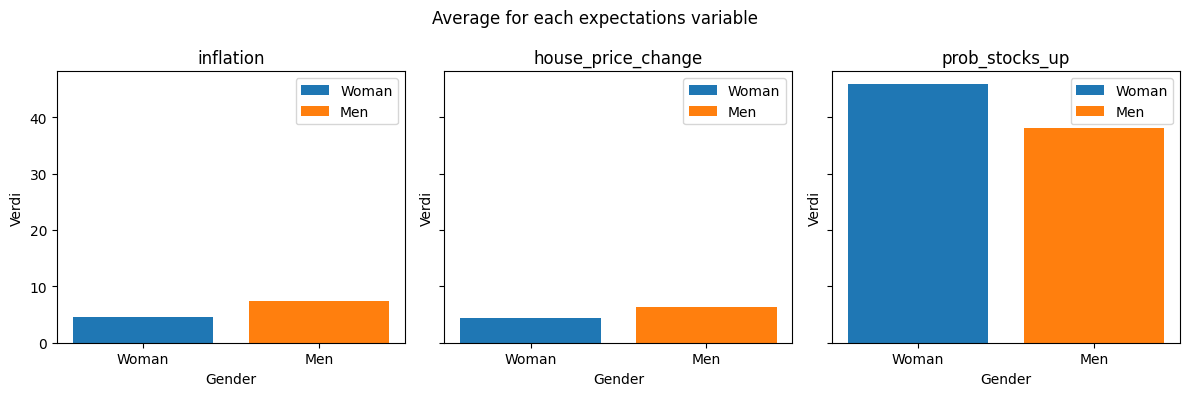

In [ ]:
df1 = GroupIndex(df, "female")
barChart(df1, "Woman", "Men", "Gender")

### 3.2 Non-college vs. college


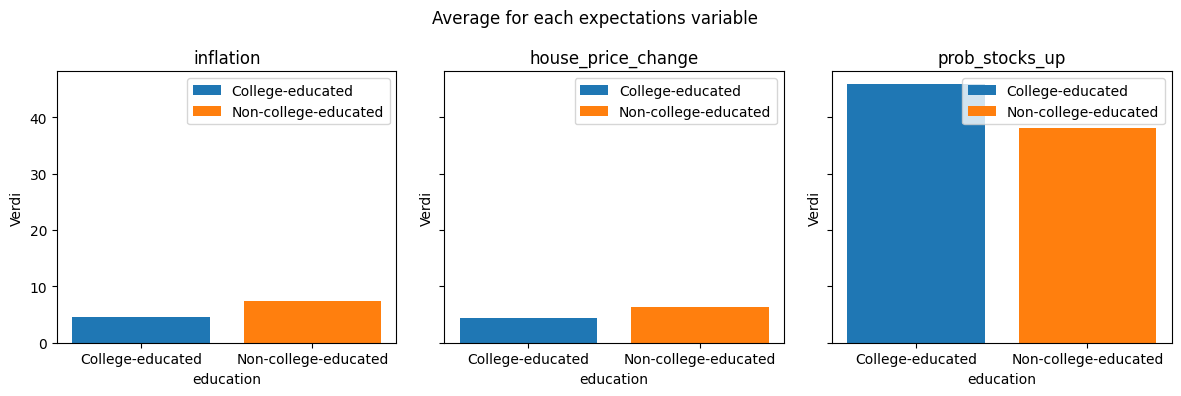

In [ ]:
df2 = GroupIndex(df, "college")
barChart(df2, "College-educated", "Non-college-educated", "education")

### 3.3  Low vs. high numeracy


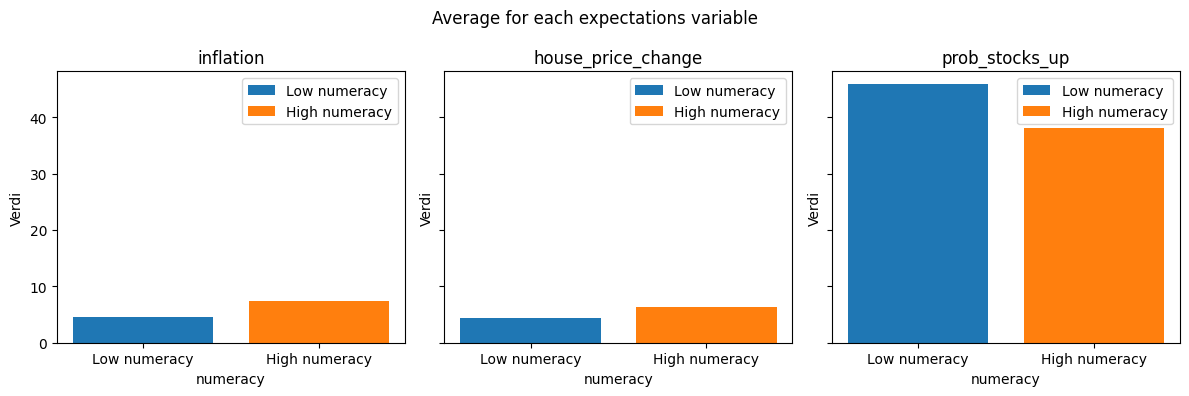

In [ ]:
df3 = GroupIndex(df, "female")
barChart(df3, "Low numeracy", "High numeracy", "numeracy")

## Part 4 — Expectation dynamics by group




### 4.1 monthly averages

This section calculates the monthly averages of inflation, house prices, and stock market values for womman and men. 

In [ ]:
def monthly_group_means(df, group_col, date_col="date"):
    """
    Collapse to monthly averages of expectations for each group value.
    Returns a monthly index DataFrame with columns as group values.
    """
    use = df[[date_col, group_col, "inflation", "house_price_change", "prob_stocks_up"]].copy()
    use[date_col] = pd.to_datetime(use[date_col], errors="coerce")
    use = use.dropna(subset=[date_col])

    # monthly key
    use["month"] = use[date_col].dt.to_period("M").dt.to_timestamp()

    # compute monthly means by group
    gb = (use
          .groupby(["month", group_col], as_index=False)[["inflation", "house_price_change", "prob_stocks_up"]]
          .mean())

    # pivot so each group is a column
    infl = gb.pivot(index="month", columns=group_col, values="inflation")
    house = gb.pivot(index="month", columns=group_col, values="house_price_change")
    stock = gb.pivot(index="month", columns=group_col, values="prob_stocks_up")

    # limit to 2015–2024 per instructions
    infl = infl.loc["2015-01":"2024-12"]
    house = house.loc["2015-01":"2024-12"]
    stock = stock.loc["2015-01":"2024-12"]

    return infl, house, stock

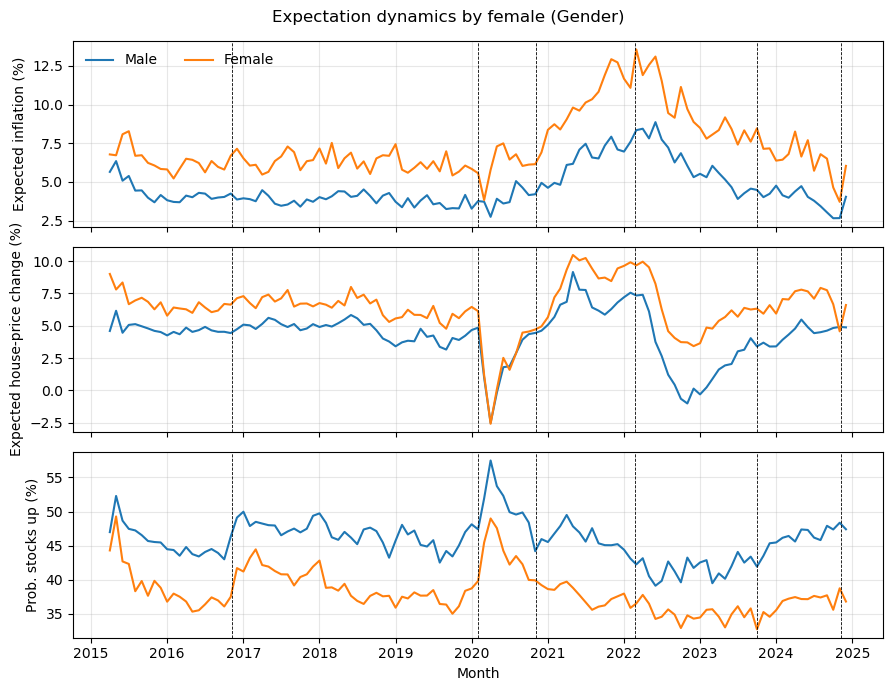

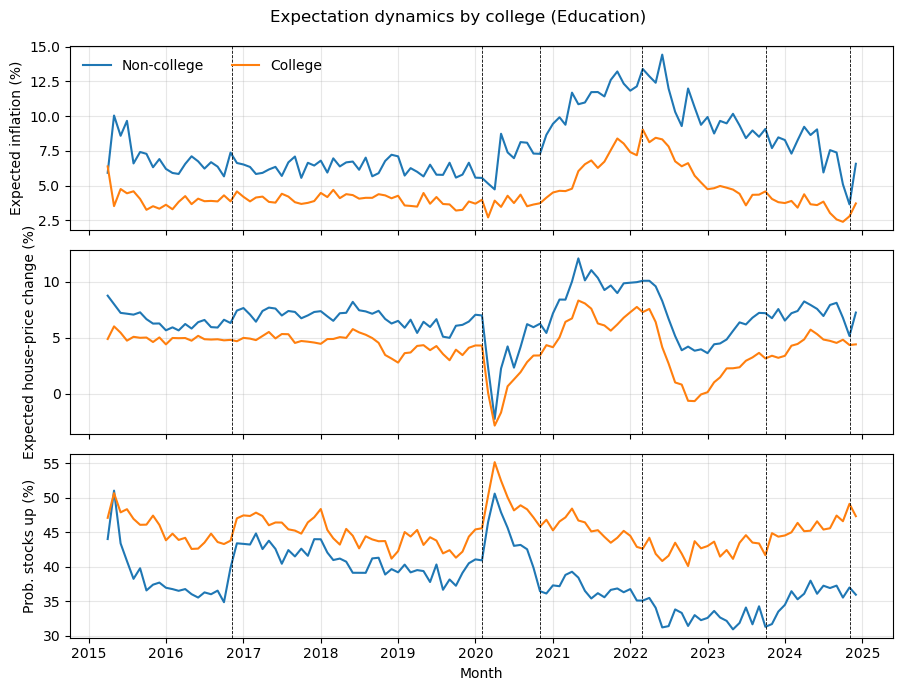

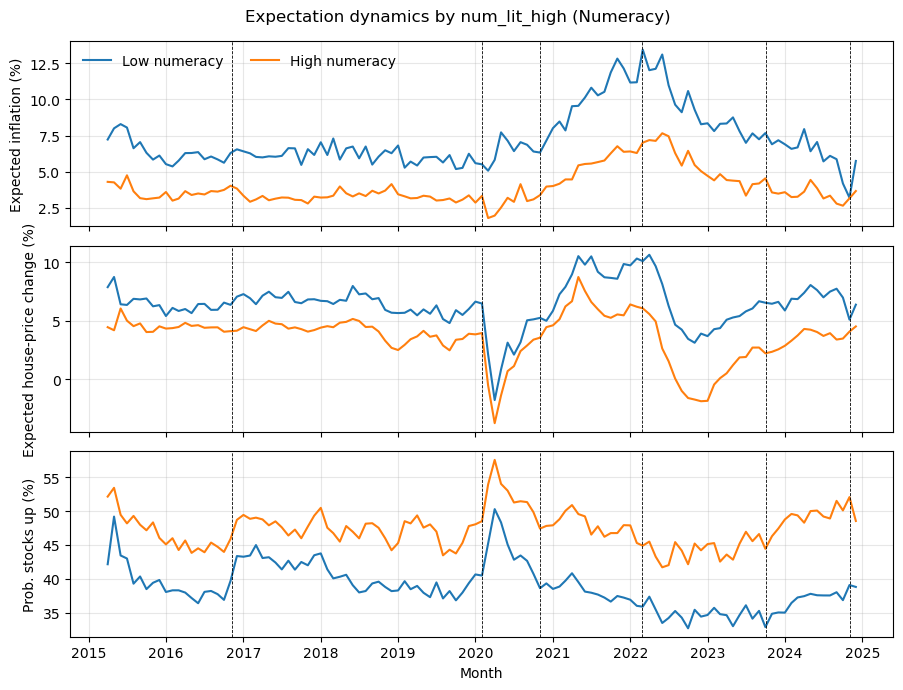

In [ ]:

# ----------------------------------------------------------
#  Part 4 – Expectation dynamics by group
# ----------------------------------------------------------

# Define the important events that will appear as vertical lines
events = [
    ("2016-11-08", "Trump elected (1st)"),
    ("2020-02-01", "COVID-19 global"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine war"),
    ("2023-10-03", "Jon Fosse Nobel"),
    ("2024-11-05", "Trump elected (2nd)"),
]

# Function to make monthly averages for a chosen group variable
def make_monthly_averages(df, group_col):
    """
    Creates a DataFrame with monthly averages of expectations for each group.
    group_col : 'female', 'college', or 'num_lit_high'
    """
    df = df.copy()
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

    # Calculate monthly means for each group
    grouped = (
        df.groupby(["month", group_col])[["inflation", "house_price_change", "prob_stocks_up"]]
          .mean()
          .reset_index()
    )

    # Keep only the period 2015–2024
    grouped = grouped[(grouped["month"] >= "2015-01-01") & (grouped["month"] <= "2024-12-31")]
    return grouped

# Function to plot three time-series panels (inflation, house, stocks)
def plot_expectations(grouped, group_col, labels_dict, title_suffix):
    """
    Plots average expectations for two groups (0/1) in three panels.
    """
    # Split data into two groups
    groups = sorted(grouped[group_col].unique())
    g0, g1 = groups[0], groups[1]

    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
    fig.suptitle(f"Expectation dynamics by {group_col} {title_suffix}")

    # ---- Panel 1: Inflation expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[0].plot(sub["month"], sub["inflation"],
                     label=labels_dict.get(g, str(g)))
    axes[0].set_ylabel("Expected inflation (%)")

    # ---- Panel 2: House-price expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[1].plot(sub["month"], sub["house_price_change"],
                     label=labels_dict.get(g, str(g)))
    axes[1].set_ylabel("Expected house-price change (%)")

    # ---- Panel 3: Stock-market expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[2].plot(sub["month"], sub["prob_stocks_up"],
                     label=labels_dict.get(g, str(g)))
    axes[2].set_ylabel("Prob. stocks up (%)")
    axes[2].set_xlabel("Month")

    # Add event lines to all panels
    for ax in axes:
        for date, label in events:
            ax.axvline(pd.to_datetime(date), color="black", linestyle="--", linewidth=0.6)
        ax.grid(True, alpha=0.3)

    # Add legend to the top panel only
    axes[0].legend(ncol=2, frameon=False)
    fig.tight_layout()
    plt.show()

# ----------------------------------------------------------
# Run the functions for each grouping variable
# ----------------------------------------------------------

# ---- (a) Gender: 0 = male, 1 = female ----
gender_data = make_monthly_averages(df_clean, "female")
plot_expectations(gender_data, "female", {0: "Male", 1: "Female"}, "(Gender)")

# ---- (b) Education: 0 = non-college, 1 = college ----
college_data = make_monthly_averages(df_clean, "college")
plot_expectations(college_data, "college", {0: "Non-college", 1: "College"}, "(Education)")

# ---- (c) Numeracy: 0 = low, 1 = high ----
numeracy_data = make_monthly_averages(df_clean, "num_lit_high")
plot_expectations(numeracy_data, "num_lit_high",
                  {0: "Low numeracy", 1: "High numeracy"}, "(Numeracy)")


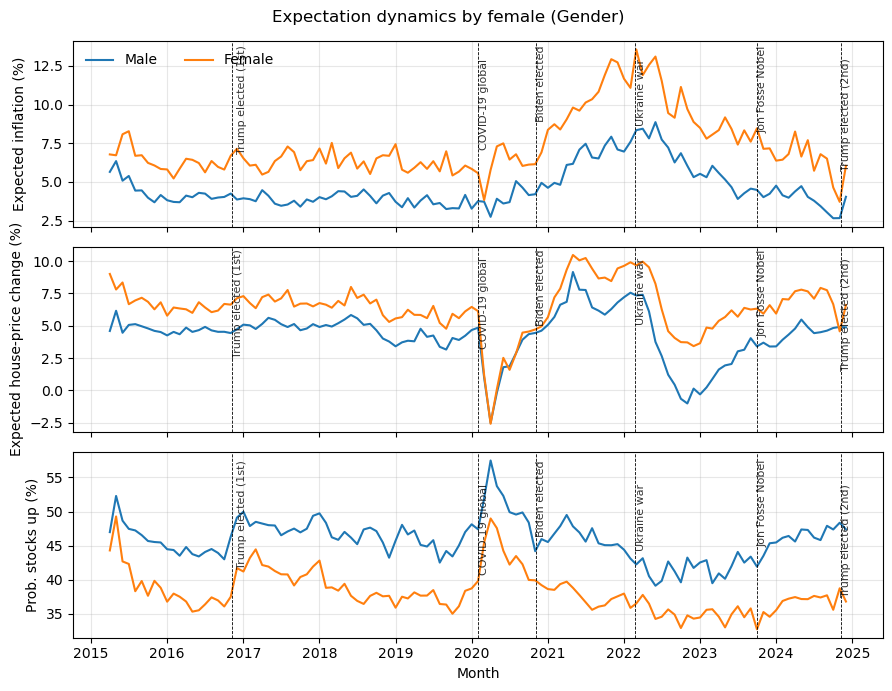

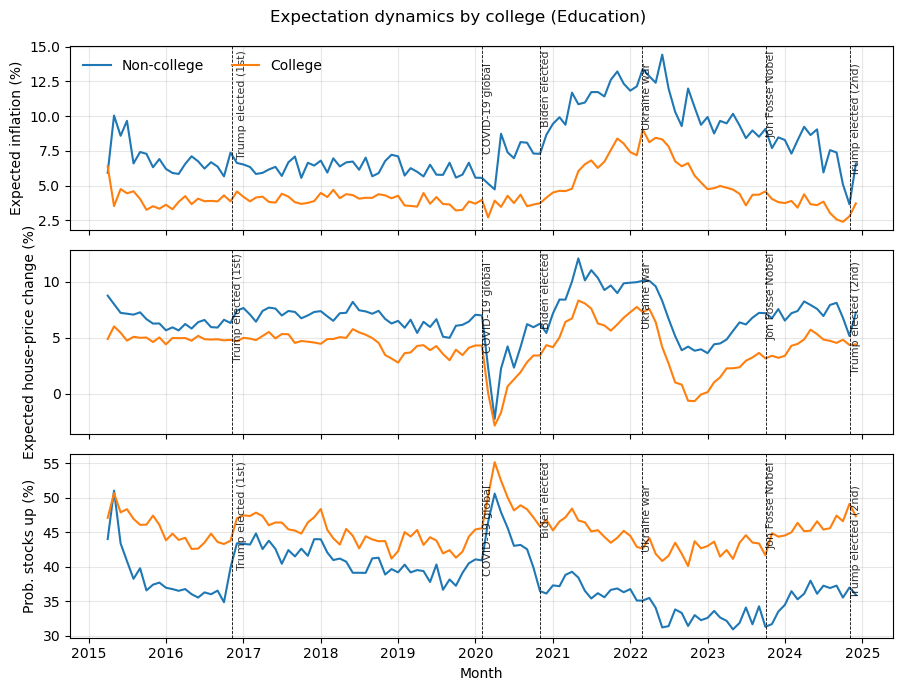

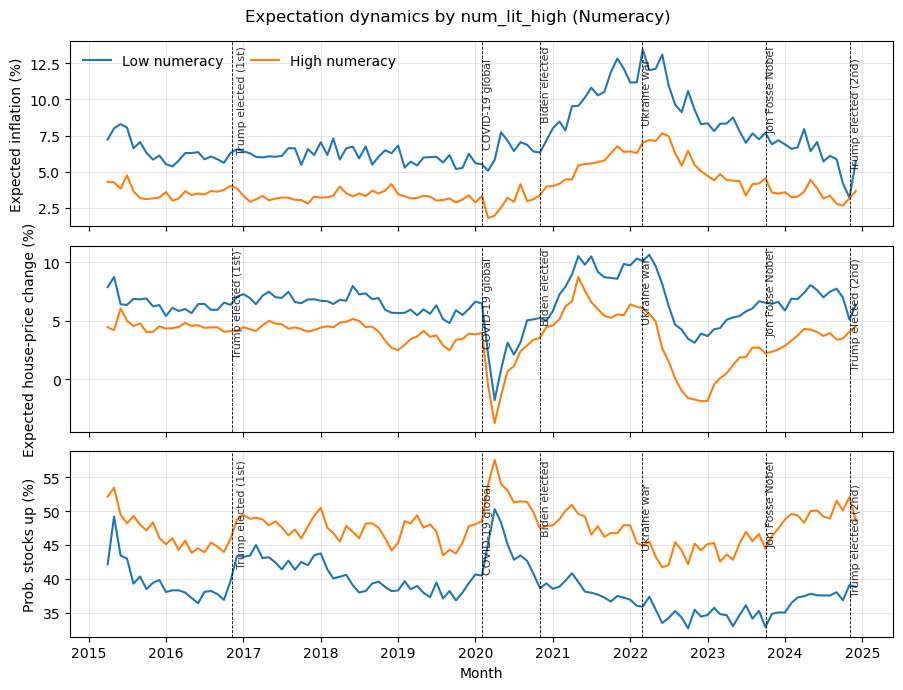

In [45]:
# ----------------------------------------------------------
#  Part 4 – Expectation dynamics by group
# ----------------------------------------------------------

# Define the important events that will appear as vertical lines
events = [
    ("2016-11-08", "Trump elected (1st)"),
    ("2020-02-01", "COVID-19 global"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine war"),
    ("2023-10-03", "Jon Fosse Nobel"),
    ("2024-11-05", "Trump elected (2nd)"),
]


# Function to make monthly averages for a chosen group variable
def make_monthly_averages(df, group_col):
    """
    Creates a DataFrame with monthly averages of expectations for each group.
    group_col : 'female', 'college', or 'num_lit_high'
    """
    df = df.copy()
    # Ensure we have a date column and it is datetime
    if "date" not in df.columns:
        raise KeyError("Expected a 'date' column in the DataFrame.")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Build a month key
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

    # Drop rows where month is NaT (unparseable dates)
    df = df.dropna(subset=["month"])

    # Compute monthly means for each group
    # Build a list of expectation columns that actually exist in the DataFrame
    cols_exist = []

    for c in ["inflation", "house_price_change", "prob_stocks_up"]:
        if c in df.columns:
            cols_exist.append(c)

    # Safety check: make sure all three expected columns are found
    if len(cols_exist) < 3:
        raise KeyError("Expected columns: 'inflation', 'house_price_change', 'prob_stocks_up'.")


    # Calculate monthly means for each group
    grouped = (
        df.groupby(["month", group_col])[["inflation", "house_price_change", "prob_stocks_up"]]
          .mean()
          .reset_index()
    )

    # Keep only the period 2015–2024
    grouped = grouped[(grouped["month"] >= "2015-01-01") & (grouped["month"] <= "2024-12-31")]
    return grouped

def plot_expectations(grouped, group_col, labels_dict, title_suffix):
    """
    Plots average expectations for two groups (0/1) in three panels,
    with vertical event lines and text labels.
    """
    groups = sorted(grouped[group_col].unique())
    g0, g1 = groups[0], groups[1]

    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
    fig.suptitle(f"Expectation dynamics by {group_col} {title_suffix}")

    # ---- Panel 1: Inflation expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[0].plot(sub["month"], sub["inflation"],
                     label=labels_dict.get(g, str(g)))
    axes[0].set_ylabel("Expected inflation (%)")

    # ---- Panel 2: House-price expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[1].plot(sub["month"], sub["house_price_change"],
                     label=labels_dict.get(g, str(g)))
    axes[1].set_ylabel("Expected house-price change (%)")

    # ---- Panel 3: Stock-market expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[2].plot(sub["month"], sub["prob_stocks_up"],
                     label=labels_dict.get(g, str(g)))
    axes[2].set_ylabel("Prob. stocks up (%)")
    axes[2].set_xlabel("Month")
    '''
    # ---- Add event lines + text labels ----
    for ax in axes:
        ylim = ax.get_ylim()  # get vertical range
        y_pos = ylim[1] * 0.98  # position near top
        for date, label in events:
            event_date = pd.to_datetime(date)
            ax.axvline(event_date, color="black", linestyle="--", linewidth=0.6)
            # Add short text next to each line
            ax.text(event_date, y_pos, label,
                    rotation=90, va="top", ha="right",
                    fontsize=8, alpha=0.75)

        ax.grid(True, alpha=0.3)
    '''
    # ---- Add event lines + staggered text labels (with legend-safe offset) ----
    for ax_idx, ax in enumerate(axes):
        ylim = ax.get_ylim()
        y_top = ylim[1]

        for i, (date, label) in enumerate(events):
            x = pd.to_datetime(date)
            ax.axvline(x, color="black", linestyle="--", linewidth=0.6)

            # Base stagger + small right shift
            y_pos = y_top * (0.98 - 0.06 * (i % 2))
            x_shift_days = 3

            # Extra nudge for the one that collides with the legend
            if "Trump elected (1st)" in label and ax_idx in (0, 2):
                x_shift_days = 25   # move label further right

            x_pos = x + pd.Timedelta(days=x_shift_days)

            ax.text(x_pos, y_pos, label,
                    rotation=90, va="top", ha="left",
                    fontsize=8, alpha=0.8)

        ax.grid(True, alpha=0.3)

    # ---- Legend and layout ----
    axes[0].legend(ncol=2, frameon=False)
    fig.tight_layout()
    plt.show()



# ----------------------------------------------------------
# Run the functions for each grouping variable
# ----------------------------------------------------------

# ---- (a) Gender: 0 = male, 1 = female ----
gender_data = make_monthly_averages(df_clean, "female")
plot_expectations(gender_data, "female", {0: "Male", 1: "Female"}, "(Gender)")

# ---- (b) Education: 0 = non-college, 1 = college ----
college_data = make_monthly_averages(df_clean, "college")
plot_expectations(college_data, "college", {0: "Non-college", 1: "College"}, "(Education)")

# ---- (c) Numeracy: 0 = low, 1 = high ----
numeracy_data = make_monthly_averages(df_clean, "num_lit_high")
plot_expectations(numeracy_data, "num_lit_high",
                  {0: "Low numeracy", 1: "High numeracy"}, "(Numeracy)")


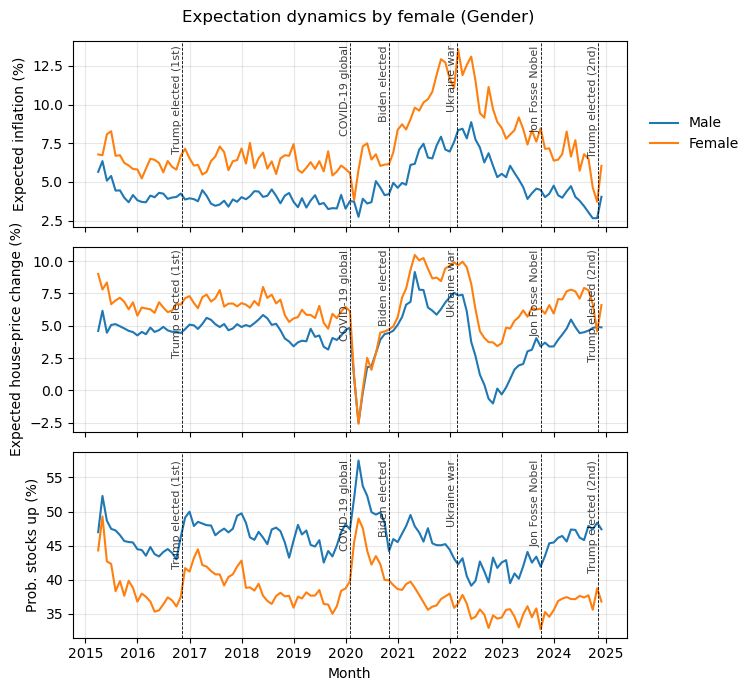

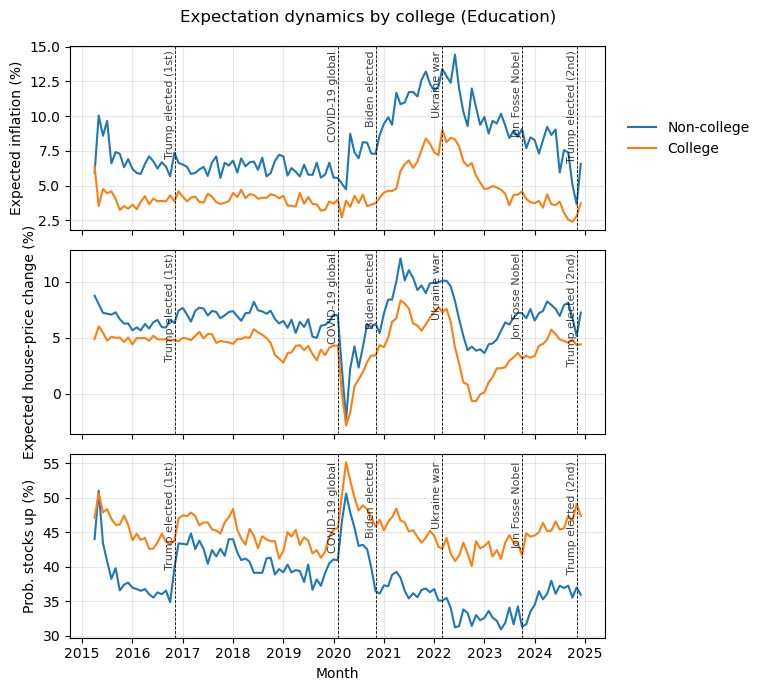

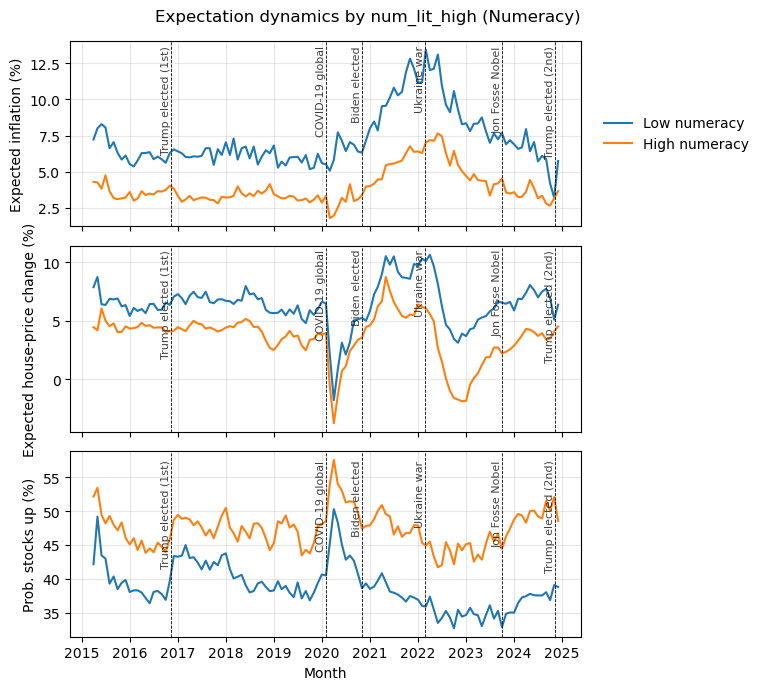

In [ ]:
# ----------------------------------------------------------
#  Part 4 – Expectation dynamics by group
# ----------------------------------------------------------

# Define the important events that will appear as vertical lines
events = [
    ("2016-11-08", "Trump elected (1st)"),
    ("2020-02-01", "COVID-19 global"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine war"),
    ("2023-10-03", "Jon Fosse Nobel"),
    ("2024-11-05", "Trump elected (2nd)"),
]

# Function to make monthly averages for a chosen group variable
def make_monthly_averages(df, group_col):
    """
    Creates a DataFrame with monthly averages of expectations for each group.
    group_col : 'female', 'college', or 'num_lit_high'
    """
    df = df.copy()
    # Ensure we have a date column and it is datetime
    if "date" not in df.columns:
        raise KeyError("Expected a 'date' column in the DataFrame.")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Build a month key
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

    # Drop rows where month is NaT (unparseable dates)
    df = df.dropna(subset=["month"])

    # Compute monthly means for each group
    # Build a list of expectation columns that actually exist in the DataFrame
    cols_exist = []

    for c in ["inflation", "house_price_change", "prob_stocks_up"]:
        if c in df.columns:
            cols_exist.append(c)

    # Safety check: make sure all three expected columns are found
    if len(cols_exist) < 3:
        raise KeyError("Expected columns: 'inflation', 'house_price_change', 'prob_stocks_up'.")


    # Calculate monthly means for each group
    grouped = (
        df.groupby(["month", group_col])[["inflation", "house_price_change", "prob_stocks_up"]]
          .mean()
          .reset_index()
    )

    # Keep only the period 2015–2024
    grouped = grouped[(grouped["month"] >= "2015-01-01") & (grouped["month"] <= "2024-12-31")]
    return grouped

def plot_expectations(grouped, group_col, labels_dict, title_suffix):
    """
    Plots average expectations for two groups (0/1) in three panels,
    with vertical event lines and text labels.
    """
    groups = sorted(grouped[group_col].unique())
    #g0, g1 = groups[0], groups[1]

    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
    fig.suptitle(
        f"Expectation dynamics by {group_col} {title_suffix}",
        x=0.4  
    )

    # ---- Panel 1: Inflation expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[0].plot(sub["month"], sub["inflation"],
                     label=labels_dict.get(g, str(g)))
    axes[0].set_ylabel("Expected inflation (%)")

    # ---- Panel 2: House-price expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[1].plot(sub["month"], sub["house_price_change"],
                     label=labels_dict.get(g, str(g)))
    axes[1].set_ylabel("Expected house-price change (%)")

    # ---- Panel 3: Stock-market expectations ----
    for g in groups:
        sub = grouped[grouped[group_col] == g]
        axes[2].plot(sub["month"], sub["prob_stocks_up"],
                     label=labels_dict.get(g, str(g)))
    axes[2].set_ylabel("Prob. stocks up (%)")
    axes[2].set_xlabel("Month")
    
    # ---- Add event lines + text labels ----
    for ax in axes:
        ylim = ax.get_ylim()  # get vertical range
        y_pos = ylim[1] * 0.98  # position near top
        for date, label in events:
            event_date = pd.to_datetime(date)
            ax.axvline(event_date, color="black", linestyle="--", linewidth=0.6)
            # Add short text next to each line
            ax.text(event_date, y_pos, label,
                    rotation=90, va="top", ha="right",
                    fontsize=8, alpha=0.75)

        ax.grid(True, alpha=0.3)
    '''
    for ax in axes:
        ylim = ax.get_ylim()
        y_top = ylim[1]

        for i, (date, label) in enumerate(events):
            x = pd.to_datetime(date)
            ax.axvline(x, color="black", linestyle="--", linewidth=0.6)

            # Stagger every other label slightly lower to avoid collisions
            # and add a tiny horizontal offset so text isn't cut at the edge.
            y_pos = y_top * (0.98 - 0.06 * (i % 2))   # 0.06 = stagger step
            x_pos = x - pd.Timedelta(days=3)          # small right shift

            ax.text(x_pos, y_pos, label,
                    rotation=90, va="top", ha="right",
                    fontsize=8, alpha=0.8)

        ax.grid(True, alpha=0.3)
    
    # ---- Legend and layout ----
    axes[0].legend(ncol=2, frameon=False)
    fig.tight_layout()
    plt.show()
    '''
    axes[0].legend(
    ncol=1, frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5)
    )

    # Leave space on the right for the legend
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    

# ----------------------------------------------------------
# 4) Run the functions for each grouping variable
# ----------------------------------------------------------

# ---- (a) Gender: 0 = male, 1 = female ----
gender_data = make_monthly_averages(df_clean, "female")
plot_expectations(gender_data, "female", {0: "Male", 1: "Female"}, "(Gender)")

# ---- (b) Education: 0 = non-college, 1 = college ----
college_data = make_monthly_averages(df_clean, "college")
plot_expectations(college_data, "college", {0: "Non-college", 1: "College"}, "(Education)")

# ---- (c) Numeracy: 0 = low, 1 = high ----
numeracy_data = make_monthly_averages(df_clean, "num_lit_high")
plot_expectations(numeracy_data, "num_lit_high",
                  {0: "Low numeracy", 1: "High numeracy"}, "(Numeracy)")


### 4.2 - Plotting expected dynamics


In [ ]:
def plot_expectation_dynamics(infl, house, stock, group_labels=None, title_suffix=""):
    """
    Draws three vertically stacked panels with two lines per panel (columns of the input frames).
    group_labels: optional dict {group_value: "Label"} to prettify legends.
    """
    # Major events (exact dates per assignment)
    events = [
        ("2016-11-08", "Trump elected (1st)"),
        ("2020-02-01", "COVID global"),
        ("2020-11-03", "Biden elected"),
        ("2022-02-24", "Russia invades Ukraine"),
        ("2023-10-03", "Jon Fosse Nobel"),
        ("2024-11-05", "Trump elected (2nd)"),
    ]  # 

    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
    panels = [
        (infl, "Expected inflation (12m ahead, %)"),
        (house, "Expected house price change (12m ahead, %)"),
        (stock, "Prob. stocks up in 12m (%)"),
    ]

    for ax, (dfp, ylab) in zip(axes, panels):
        # plot each group column
        for col in dfp.columns:
            lab = group_labels.get(col, str(col)) if group_labels else str(col)
            ax.plot(dfp.index, dfp[col], label=lab, linewidth=1.4)

        # event lines
        for d, label in events:
            ax.axvline(pd.to_datetime(d), color="black", linestyle="--", linewidth=0.6)
            ax.text(pd.to_datetime(d), ax.get_ylim()[1], label, rotation=90,
                    va="top", ha="right", fontsize=8, alpha=0.8)

        ax.grid(True, alpha=0.3)
        ax.set_ylabel(ylab)

    axes[-1].set_xlabel("Month")
    axes[0].set_title(f"Expectation dynamics by group {title_suffix}")
    axes[0].legend(ncol=2, frameon=False)
    fig.tight_layout()
    return fig, axes

### 4.3  how expectations reacted to important geopolitical events


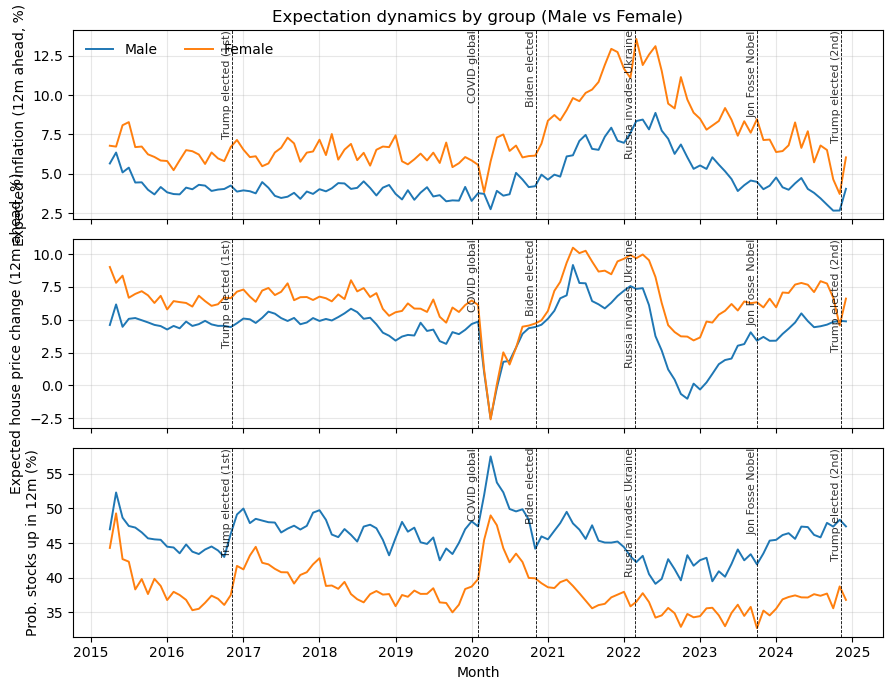

In [ ]:
# A) Gender: 0 = male, 1 = female  (use your own labels if needed)
infl_f, house_f, stock_f = monthly_group_means(df, "female")
fig_f, axes_f = plot_expectation_dynamics(
    infl_f, house_f, stock_f,
    group_labels={0: "Male", 1: "Female"},
    title_suffix="(Male vs Female)"
)

## Part 5

### 5.1.1 + 5.1.2

In [ ]:
cpi

,DATE,CPI
0,1947-01-01,21.5
1,1947-02-01,21.6
2,1947-03-01,22.0
3,1947-04-01,22.0
4,1947-05-01,22.0
...,...,...
939,2025-04-01,320.3
940,2025-05-01,320.6
941,2025-06-01,321.5
942,2025-07-01,322.1


In [ ]:
def compute_merge_inflation(cpi_data, infl_gender):
    # Prepare CPI series with datetime monthly index
    cpi_idx = cpi_data.copy()
    cpi_idx['DATE'] = pd.to_datetime(cpi_idx['DATE'])
    cpi_idx = cpi_idx.set_index('DATE').sort_index()
    cpi_idx.index = cpi_idx.index.to_period('M').to_timestamp()

    # Forward-looking 12-month inflation
    cpi_idx['inflation_forward_12m'] = (cpi_idx['CPI'].shift(-12) - cpi_idx['CPI']) / cpi_idx['CPI'] * 100

    # Restrict to the analysis window and keep only forward-looking inflation
    cpi_fw = cpi_idx.loc['2015-01':'2024-12', ['inflation_forward_12m']].copy()

    # Rename gender columns for clarity and merge
    merged = infl_gender.rename(columns={0.0: 'exp_infl_male', 1.0: 'exp_infl_female'})
    return merged.join(cpi_fw, how='inner')

cpi_gender = compute_merge_inflation(cpi, infl_f)
cpi_gender


,exp_infl_male,exp_infl_female,inflation_forward_12m
2015-04-01,5.652381,6.780556,1.185436
2015-05-01,6.348507,6.725000,1.097046
2015-06-01,5.082990,8.083133,1.051746
2015-07-01,5.388933,8.281395,0.882353
2015-08-01,4.441356,6.692032,1.050420
...,...,...,...
2024-08-01,3.437044,6.796481,2.960840
2024-09-01,3.034840,6.508769,NaN
2024-10-01,2.655388,4.644612,NaN
2024-11-01,2.663529,3.714314,NaN


### 5.1.3

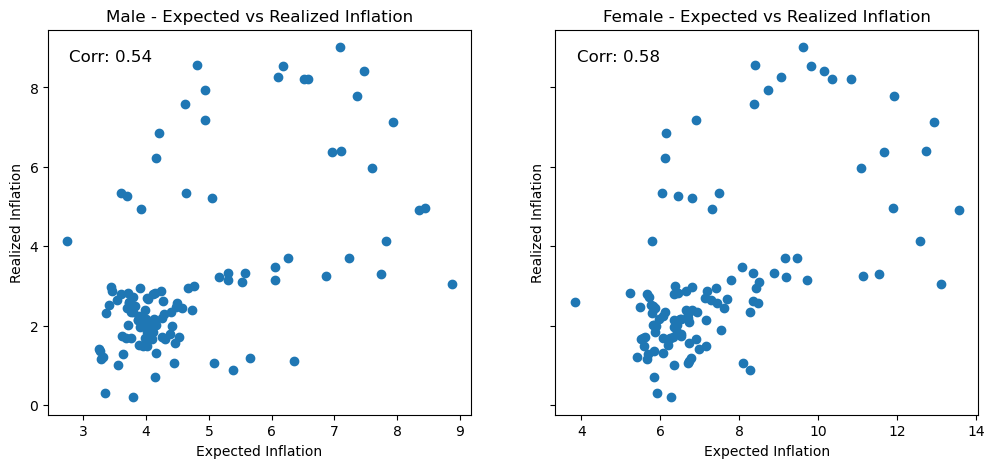

In [ ]:
'''Create a figure with two panels (one per gender), each showing a scatter plot of realized
future inflation (y-axis) versus average expected inflation by gender.
Compute the correlation between expected and realized inflation for each gender and add
the correlation coefficient as text to the corresponding panel'''

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, gender in enumerate(['male', 'female']):
    ax = axes[i]
    x = merged[f'exp_infl_{gender}']
    y = merged['inflation_forward_12m']
    ax.scatter(x, y)
    ax.set_title(f'{gender.capitalize()} - Expected vs Realized Inflation')
    ax.set_xlabel('Expected Inflation')
    ax.set_ylabel('Realized Inflation')
    corr = x.corr(y)
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

### 5.2

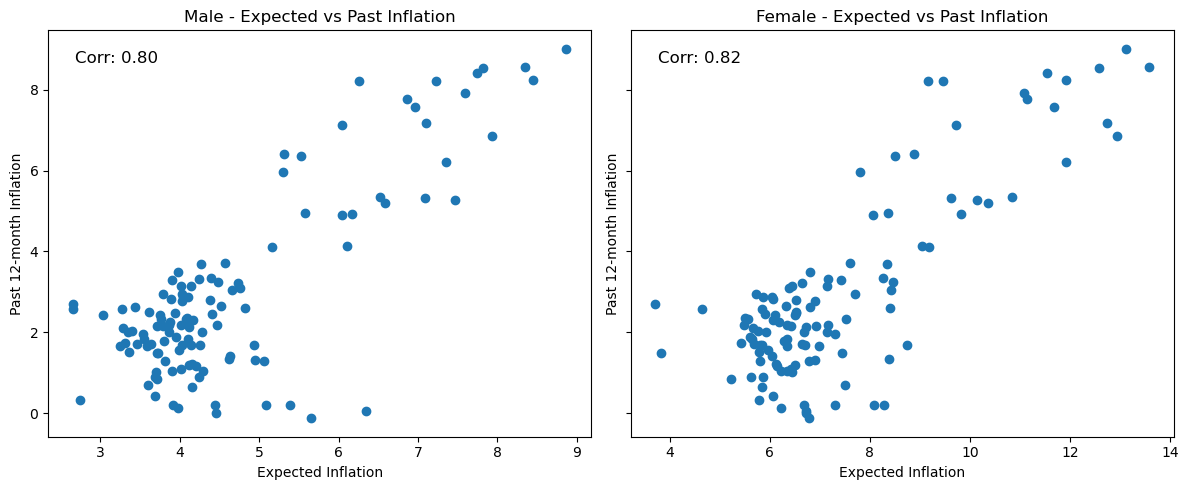

In [ ]:
# Compute backward-looking 12-month inflation
cpi_idx['inflation_backward_12m'] = ((cpi_idx['CPI'] - cpi_idx['CPI'].shift(12)) / cpi_idx['CPI'].shift(12) * 100)

# Create a new merged dataframe with backward-looking inflation
merged_backward = infl_f.rename(columns={0.0: 'exp_infl_male', 1.0: 'exp_infl_female'}).join(cpi_idx[['inflation_backward_12m']])

# Create figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, gender in enumerate(['male', 'female']):
    ax = axes[i]
    x = merged_backward[f'exp_infl_{gender}']
    y = merged_backward['inflation_backward_12m']
    ax.scatter(x, y)
    ax.set_title(f'{gender.capitalize()} - Expected vs Past Inflation')
    ax.set_xlabel('Expected Inflation')
    ax.set_ylabel('Past 12-month Inflation')
    corr = x.corr(y)
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()

## Sources: 
- Generative AI: used for identifying bugs and suggested correction

## 